In [161]:
import numpy as np
import pandas as pd
import datetime 


In [162]:
#data prep
p1 = r'C:\Users\kunal.mishra\Downloads\NQH25-CME-BarStudyData.csv'

df_1m = pd.read_csv(p1)
df_1m.columns = df_1m.columns.str.strip()
df_1m['Timestamp'] = pd.to_datetime(df_1m['Date'] + ' ' + df_1m['Time'])
df_1m.set_index(df_1m['Timestamp'],inplace=True)

df_1m.drop(columns = ['Date','Time'], inplace = True)
df_1m.drop(columns = df_1m.columns[-9:],axis = 1, inplace = True) #dropping irrelevant columns 

df_1m.dropna(inplace=True)
print(df_1m.head())

df_5m = df_1m.resample('5min').aggregate({
    'Open':'first',
    'High':'max',
    'Low':'min',
    'Last':'last'
})
df_15m = df_1m.resample('15min').aggregate({
    'Open':'first',
    'High':'max',
    'Low':'min',
    'Last':'last'
})

df_5m.dropna(inplace=True)
df_15m.dropna(inplace=True)


                        Open     High      Low     Last  Volume
Timestamp                                                      
2009-11-27 03:26:00  3756.25  3756.50  3756.25  3756.50       4
2009-11-27 04:54:00  3750.50  3750.50  3750.50  3750.50       1
2009-11-27 05:00:00  3746.50  3748.75  3745.25  3745.25      10
2009-11-27 05:48:00  3740.75  3740.75  3740.75  3740.75       1
2009-11-27 06:19:00  3742.00  3742.00  3742.00  3742.00       1


In [163]:
# range formation

NrmlOpenTime = datetime.time(13,30)
NrmlClose = datetime.time(13,45)

DaylightOpenTime = datetime.time(14,30)
DaylightClose = datetime.time(14,45)

NrmlMonth = list(range(3,11))
DaylightMonth = [11,12,1,2]

    #data drop prior to US open 
df_5m = df_5m[((df_5m.index.month.isin(NrmlMonth)) & (df_5m.index.time >= NrmlOpenTime)) | ((df_5m.index.month.isin(DaylightMonth)) & (df_5m.index.time >= DaylightOpenTime))]  

range_mask_nrml = ((df_5m.index.month.isin(NrmlMonth)) & ((df_5m.index.time >= NrmlOpenTime) & (df_5m.index.time <= NrmlClose)))
range_mask_dayLight = ((df_5m.index.month.isin(DaylightMonth)) & ((df_5m.index.time >= DaylightOpenTime) & (df_5m.index.time <= DaylightClose)))
range_final = range_mask_nrml | range_mask_dayLight


df_5m.loc[range_final,'Range High'] = df_5m.loc[range_final].groupby(df_5m.loc[range_final].index.date)['High'].transform('max')
df_5m.loc[range_final,'Range Low'] =  df_5m.loc[range_final].groupby(df_5m.loc[range_final].index.date)['Low'].transform('min')

df_5m['Range High'] = df_5m.groupby(df_5m.index.date)['Range High'].ffill()
df_5m['Range Low'] = df_5m.groupby(df_5m.index.date)['Range Low'].ffill()
df_5m.dropna(inplace=True)
df_5m.reset_index(inplace=True)
print(df_5m.head())


            Timestamp     Open     High      Low     Last  Range High  \
0 2009-11-27 14:30:00  3750.25  3753.00  3746.25  3753.00      3763.0   
1 2009-11-27 14:35:00  3755.50  3756.50  3755.50  3756.50      3763.0   
2 2009-11-27 14:40:00  3756.75  3763.00  3756.75  3763.00      3763.0   
3 2009-11-27 14:45:00  3757.75  3758.00  3757.75  3758.00      3763.0   
4 2009-11-27 14:50:00  3761.75  3761.75  3761.75  3761.75      3763.0   

   Range Low  
0    3746.25  
1    3746.25  
2    3746.25  
3    3746.25  
4    3746.25  


In [164]:
#trade analysis

df_5m['Entry'] = 0
df_5m['Exit'] = 0

tick_size = 0.25
tick_value = 0.5
lot_size = 1
tick_sl = 200*tick_size  # 200 ticks for SL

i = 0
while i < len(df_5m):

    current_day = df_5m.at[i,'Timestamp'].date()
    current_price = df_5m.at[i,'Last']
    range_high = df_5m.at[i,'Range High']
    range_low = df_5m.at[i,'Range Low']

    long_sl = range_high - tick_sl
    short_sl = range_low + tick_sl 

    #lot_size = round((risk_per_trade)/(((range_high - range_low) / tick_size)*tick_value))

    high_break = current_price > range_high
    low_break = current_price < range_low
    
    if high_break:
        df_5m.at[i,'Entry'] = 1*lot_size
        
        trade_day = current_day
        while trade_day == current_day:
 
            if df_5m.at[i,'Last'] <= long_sl:
                df_5m.at[i,'Exit'] = -1*lot_size
                break 
            
            i+=1
            if i >= len(df_5m):              #out of bounds 
                df_5m.at[i-1,'Exit'] = -1*lot_size
                break

            trade_day = df_5m.at[i,'Timestamp'].date()
            if trade_day != current_day:
                df_5m.at[i-1,'Exit'] = -1*lot_size

    elif low_break:
        df_5m.at[i,'Entry'] = -1*lot_size
        
        trade_day = current_day
        while trade_day == current_day:

            if df_5m.at[i,'Last'] >= short_sl:
                df_5m.at[i,'Exit'] = 1*lot_size
                break
            
            i+=1
            if i >= len(df_5m):
                df_5m.at[i-1,'Exit'] = 1*lot_size
                break

            trade_day = df_5m.at[i,'Timestamp'].date()
            if trade_day!=current_day:
                df_5m.at[i-1,'Exit'] = 1*lot_size


    i+=1


In [165]:
#trade stats
rt_cost = 0.5

df_5m_entry = df_5m.loc[df_5m['Entry']!=0,['Timestamp','Entry','Last']] 
df_5m_entry.rename(columns={'Last':'Entry Price','Timestamp':'Entry Time'},inplace  =True)
df_5m_exit = df_5m.loc[df_5m['Exit']!=0,['Timestamp','Exit','Last']] 
df_5m_exit.rename(columns={'Last':'Exit Price','Timestamp':'Exit Time'},inplace  =True)

df_5m_entry.reset_index(drop = True, inplace = True)
df_5m_exit.reset_index(drop = True, inplace = True)
df_stats = pd.concat([df_5m_entry,df_5m_exit], axis = 1)

df_stats['Trade Duration (hours)'] = (df_stats['Exit Time']-df_stats['Entry Time']).dt.total_seconds()/3600
df_stats['Gross($)'] = ((df_stats['Entry']*df_stats['Entry Price'] + df_stats['Exit']*df_stats['Exit Price']) / tick_size)*tick_value
df_stats['Cost'] = abs(df_stats['Entry'])*rt_cost
df_stats['Net($)'] = df_stats['Gross($)'] - df_stats['Cost']
df_stats['Cummulative'] = df_stats['Net($)'].cumsum()

print(f"Cummulative Pnl  = {df_stats['Net($)'].sum()}")
print(f"Hit ratio = {(df_stats['Net($)']>0).sum() / df_stats['Net($)'].count():.2f}")
print(f"AVerage RR = {df_stats.loc[df_stats['Gross($)']>0,'Gross($)'].sum() / abs(df_stats.loc[df_stats['Gross($)']<0,'Gross($)'].sum()):.2f}")
print(f"Pnl Std dev  = {df_stats['Cummulative'].std():.2f}")
print(f"Trade Freq = {df_stats.shape[0] / len((df_5m['Timestamp'].dt.date).unique())}")
print(f"Sharpe = {df_stats['Net($)'].mean()/df_stats['Net($)'].std()}")

Cummulative Pnl  = -85175.5
Hit ratio = 0.54
AVerage RR = 0.93
Pnl Std dev  = 19461.34
Trade Freq = 1.4998689384010484
Sharpe = -0.036262261721015966


Text(0, 0.5, 'Cum PnL')

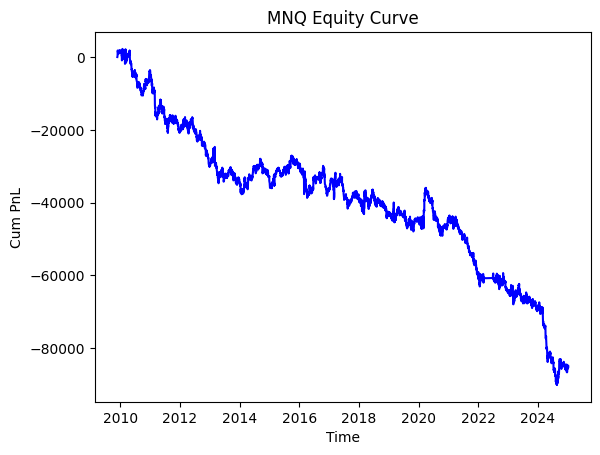

In [166]:
import matplotlib.pyplot as plt

plt.plot(df_stats['Entry Time'].dt.date,df_stats['Cummulative'],color = 'blue')
plt.title('MNQ Equity Curve')
plt.xlabel('Time')
plt.ylabel('Cum PnL')